In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### Summary

In [146]:
import os

specs_dir = "specs"
base_name = "signal"
suffix = "_l1_0.5_clust"  # adapt for different l1_ratios if needed

models = ["lasso", "ridge", "elastic"]

summary_data = []

for model in models:
    for l1_ratio in ([0.25, 0.5, 0.75] if model == "elastic" else [None]):
        label = f"{model.capitalize()}" if l1_ratio is None else f"Elastic Net (L1={l1_ratio})"
        file_name = (f"{model}_{base_name}_l1_{l1_ratio}_clust_results.dat"
                     if model == "elastic"
                     else f"{model}_{base_name}_clust_results.dat")
        path = os.path.join(specs_dir, file_name)
        if not os.path.exists(path):
            continue
        df = pd.read_pickle(path)
        best = df.loc[df['R²_test'].idxmax()]
        reject = 'Accepted' if (pd.notna(best['DM_p']) and best['DM_p'] < 0.05) else 'Rejected'
        summary_data.append({
            "Model": label,
            "R²_test": best['R²_test'],
            "RMSE_test": best['RMSE_test'],
            "ΔR² vs Benchmark": best['R²_test'] - 0.907,  # example benchmark
            "ΔRMSE vs Benchmark": best['RMSE_test'] - 1.27,
            "H1=Incremental signal present": reject,
            "DM_stat": best['DM_stat'],
            "DM_p": best['DM_p'],
        })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("R²_test", ascending=False)
print("="*80)
print("INCREMENTAL SIGNAL REGRESSIONS — PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

INCREMENTAL SIGNAL REGRESSIONS — PERFORMANCE SUMMARY
                Model  R²_test  RMSE_test  ΔR² vs Benchmark  ΔRMSE vs Benchmark H1=Incremental signal present  DM_stat     DM_p
                Lasso 0.894176   1.306056         -0.012824            0.036056                      Rejected 1.148927 0.250586
                Ridge 0.893757   1.308637         -0.013243            0.038637                      Rejected 1.421045 0.155304
Elastic Net (L1=0.75) 0.893680   1.309112         -0.013320            0.039112                      Rejected 1.128916 0.258933
 Elastic Net (L1=0.5) 0.893648   1.309309         -0.013352            0.039309                      Rejected 1.239208 0.215269
Elastic Net (L1=0.25) 0.893579   1.309736         -0.013421            0.039736                      Rejected 1.257773 0.208474


In [124]:
import os
import re
from functions.labels import *

def simplify_label(label):
    base = label.split('.')[-1].strip()
    base = re.sub(r'\(.*?\)', '', base).strip()
    return base

specs_dir = "specs"
base_name = "levels"
suffix = "_agn"

model_configs = [
    ('lasso', None),
    ('ridge', None),
    ('elastic', 0.25),
    ('elastic', 0.5),
    ('elastic', 0.75)
]

summary_rows = []
all_top_vars = []

for model_type, l1_ratio in model_configs:
    if model_type == 'elastic':
        model_label = f"Elastic Net (L1={l1_ratio})"
        file_base = f"{model_type}_{base_name}{suffix}_l1_{l1_ratio}_clust"
    else:
        model_label = model_type.capitalize()
        file_base = f"{model_type}_{base_name}{suffix}_clust"
    results_path = os.path.join(specs_dir, f"{file_base}_results.dat")
    core_shap_path = os.path.join(specs_dir, f"{file_base}_core_shap.dat")
    core_stability_path = os.path.join(specs_dir, f"{file_base}_core_stability.dat")
    results_df = pd.read_pickle(results_path)
    best_idx = results_df['R²_test'].idxmax()
    best = results_df.iloc[best_idx]
    core_shap = pd.read_pickle(core_shap_path)
    stable_cores = set()
    if os.path.exists(core_stability_path):
        core_stability = pd.read_pickle(core_stability_path)
        stable_cores = set(core_stability['core_variable'].values)

    top5 = core_shap.head(5).copy()
    top5['stable'] = top5['core_variable'].isin(stable_cores)
    top5['model'] = model_label

    summary_rows.append({
        'Model': model_label,
        'R²_test': best['R²_test'],
        'R²_train': best['R²_train'],
        'RMSE_test': best['RMSE_test']
    })

    for _, row in top5.iterrows():
        var_name = row['core_variable'] + ('*' if row['stable'] else '')
        all_top_vars.append({
            'Model': model_label,
            'Variable': var_name,
            'SHAP': row['shap_importance'],
            'SHAP_pct': row['shap_importance_pct']
        })

summary_df = pd.DataFrame(summary_rows)
print("="*80)
print("PRICED-IN LEVELS - REGRESSIONS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("TOP 5 VARIABLES BY SHAP IMPORTANCE (per model)")
print("* indicates stable variable from stability selection (not performed for Ridge)")
print("="*80)

top_vars_df = pd.DataFrame(all_top_vars)
for model in top_vars_df['Model'].unique():
    print(f"\n{model}:")
    model_vars = top_vars_df[top_vars_df['Model'] == model]
    for _, row in model_vars.iterrows():
        var_core = row['Variable'].replace('*', '')
        var_label = simplify_label(get_label(var_core))
        stability_marker = '*' if '*' in row['Variable'] else ''
        print(f"  {var_label}{stability_marker}: {row['SHAP']:.4f} ({row['SHAP_pct']:.2f}%)")

shap_pivot = pd.DataFrame(all_top_vars)
shap_pivot['core_variable'] = shap_pivot['Variable'].str.replace('*', '', regex=False)
all_core_vars = shap_pivot['core_variable'].unique()
shap_detail = pd.DataFrame(all_top_vars)
shap_detail['core_variable'] = shap_detail['Variable'].str.replace('*', '', regex=False)
shap_detail['label'] = shap_detail['core_variable'].apply(lambda x: simplify_label(get_label(x)))

complete_shap_data = []
for model_type, l1_ratio in model_configs:
    if model_type == 'elastic':
        model_label = f"EN (L1={l1_ratio})"
        file_base = f"{model_type}_{base_name}{suffix}_l1_{l1_ratio}_clust"
    else:
        model_label = model_type.upper()
        file_base = f"{model_type}_{base_name}{suffix}_clust"
    core_shap_path = os.path.join(specs_dir, f"{file_base}_core_shap.dat")
    full_core_shap = pd.read_pickle(core_shap_path)

    relevant_vars = full_core_shap[full_core_shap['core_variable'].isin(all_core_vars)].copy()
    relevant_vars['Model'] = model_label
    relevant_vars['label'] = relevant_vars['core_variable'].apply(lambda x: simplify_label(get_label(x)))
    complete_shap_data.append(relevant_vars[['label', 'Model', 'shap_importance_pct']])

complete_df = pd.concat(complete_shap_data, ignore_index=True)
pivot_table = complete_df.pivot_table(values='shap_importance_pct',
                                     index='label',
                                     columns='Model',
                                     fill_value=0.0).round(2)

pivot_table['Average'] = pivot_table.mean(axis=1).round(2)
pivot_table = pivot_table.sort_values('Average', ascending=False)

desired_order = ['RIDGE', 'EN (L1=0.25)', 'EN (L1=0.5)', 'EN (L1=0.75)', 'LASSO']
existing_cols = [c for c in desired_order if c in pivot_table.columns]
remaining_cols = [c for c in pivot_table.columns if c not in existing_cols]
pivot_table = pivot_table[existing_cols + remaining_cols]

print("\n" + "="*80)
print("SHAP IMPORTANCE BY MODEL AND VARIABLE (%)")
print("="*80)
print(pivot_table.to_string())

PRICED-IN LEVELS - REGRESSIONS SUMMARY
                Model  R²_test  R²_train  RMSE_test
                Lasso 0.514568  0.790401   2.919736
                Ridge 0.554868  0.744029   2.795915
Elastic Net (L1=0.25) 0.508562  0.849222   2.937741
 Elastic Net (L1=0.5) 0.509748  0.820254   2.934197
Elastic Net (L1=0.75) 0.517463  0.800170   2.911017

TOP 5 VARIABLES BY SHAP IMPORTANCE (per model)
* indicates stable variable from stability selection (not performed for Ridge)

Lasso:
  Integrity of the Legal System*: 0.5643 (21.18%)
  Monetary Freedom*: 0.5613 (21.07%)
  Military Interference in Rule of Law and Politics*: 0.3026 (11.36%)
  Costs of Importing and Exporting*: 0.2530 (9.50%)
  Current Account Balance*: 0.2459 (9.23%)

Ridge:
  Real GDP Growth: 0.4942 (4.85%)
  Current Account Balance: 0.3350 (3.29%)
  Monetary Freedom: 0.2747 (2.69%)
  Costs of Importing and Exporting: 0.2528 (2.48%)
  State Ownership of Assets: 0.2518 (2.47%)

Elastic Net (L1=0.25):
  Monetary Freedom*: 0.6

### Function

In [144]:
import os, time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from joblib import Parallel, delayed
import shap
import warnings

def filter_cols(cols, exclude_endings):
    return [c for c in cols if not any(c.endswith(ending) for ending in exclude_endings)]

def _yearwise_splits(years, min_train_years=8, stride=2):
    ys = np.asarray(years)
    uniq = np.sort(np.unique(ys))
    for k in range(min_train_years, len(uniq), stride):
        train = np.where(np.isin(ys, uniq[:k]))[0]
        val = np.where(ys == uniq[k])[0]
        yield train, val

def _rmse_for_param(param, X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2):
    rmse = []
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3, warm_start=False)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    for tr, va in _yearwise_splits(years, min_train_years, stride):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        rmse.append(np.sqrt(mean_squared_error(y.iloc[va], pred)))
    return param, float(np.mean(rmse)) if rmse else np.inf

def choose_param_expanding_fast(X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2, n_jobs=-1):
    if model_type == 'lasso':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            lasso_cv = LassoCV(alphas=alphas, cv=cv_folds, max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            lasso_cv.fit(X, y)
            return lasso_cv.alpha_

    elif model_type == 'elastic':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=[l1_ratio], cv=cv_folds,
                                    max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            elastic_cv.fit(X, y)
            return elastic_cv.alpha_

    params_coarse = np.logspace(0, 5, 15) if model_type == 'ridge' else np.logspace(-4, 1, 12)
    coarse = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(params_coarse, reverse=True)
    )
    p0 = min(coarse, key=lambda t: t[1])[0]
    low, high = p0/5, p0*5
    fine_grid = np.logspace(np.log10(low), np.log10(high), 8)
    fine = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(fine_grid, reverse=True)
    )
    return min(fine, key=lambda t: t[1])[0]

def _fit_model_for_factor(factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                         y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic):
    param = optimal_param * factor
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)

    model.fit(X_train, y_train_adj)
    y_pred_test_adj = model.predict(X_test)
    y_pred_train_adj = model.predict(X_train)

    if not agnostic:
        y_pred_test = spread_test + y_pred_test_adj
        y_pred_train = spread_train + y_pred_train_adj
    else:
        y_pred_test = y_pred_test_adj
        y_pred_train = y_pred_train_adj

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    active_vars = np.sum(model.coef_ != 0)

    if not agnostic:
        e_benchmark = y_test - spread_test
        e_model = y_test - y_pred_test
        dm_stat, dm_p = _dm_test(e_benchmark, e_model)
    else:
        dm_stat, dm_p = np.nan, np.nan

    return {
        'factor': factor,
        'param': param,
        'R²_train': r2_train,
        'R²_test': r2_test,
        'RMSE_test': rmse_test,
        'Active_vars': active_vars,
        'DM_stat': dm_stat,
        'DM_p': dm_p,
        'model': model,
        'predictions': y_pred_test
    }

def _dm_test(e0, e1):
    d = e0**2 - e1**2
    T = len(d)
    v = np.var(d, ddof=1)
    if T < 2 or v == 0 or np.isnan(v):
        return np.nan, np.nan
    stat = d.mean() / np.sqrt(v / T)
    pval = 2 * (1 - norm.cdf(abs(stat)))
    return stat, pval

def cluster_features(X_train, y_train=None, corr_threshold=0.75, method='complete'):
    def extract_core(var):
        suffixes = ['_delta3', '_delta', '_t-5', '_t-3', '_t-2', '_t-1', '_ma10', '_ma5', '_ma3']
        for s in suffixes:
            if var.endswith(s):
                return var[:-len(s)]
        return var

    core_groups = {}
    for v in X_train.columns:
        core = extract_core(v)
        core_groups.setdefault(core, []).append(v)

    cluster_map = {}
    representative_vars = []
    cluster_id = 0
    cluster_records = []

    for core, vars_in_core in core_groups.items():
        if len(vars_in_core) == 1:
            cluster_id += 1
            var = vars_in_core[0]
            cluster_map[cluster_id] = [var]
            representative_vars.append(var)
            cluster_records.append({'variable': var, 'cluster': cluster_id})
            continue

        corr_matrix = X_train[vars_in_core].corr().abs()
        distance_matrix = 1 - corr_matrix
        condensed_dist = squareform(distance_matrix, checks=False)
        linkage_matrix = linkage(condensed_dist, method=method)
        clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

        for subcluster_id in np.unique(clusters):
            cluster_id += 1
            cluster_vars = [vars_in_core[i] for i, c in enumerate(clusters) if c == subcluster_id]
            cluster_map[cluster_id] = cluster_vars

            if y_train is not None:
                corrs = X_train[cluster_vars].corrwith(y_train)
                rep_var = corrs.abs().idxmax()
            else:
                variances = X_train[cluster_vars].var()
                rep_var = variances.idxmax()

            representative_vars.append(rep_var)
            for v in cluster_vars:
                cluster_records.append({'variable': v, 'cluster': cluster_id})

    cluster_df = pd.DataFrame(cluster_records)
    return representative_vars, cluster_map, cluster_df

def extract_core_variable(var_name):
    suffixes = ['_delta3', '_delta', '_t-5', '_t-4', '_t-3', '_t-2', '_t-1',
                '_ma10', '_ma5', '_ma3']
    for suffix in suffixes:
        if var_name.endswith(suffix):
            return var_name[:-len(suffix)]
    return var_name

def aggregate_by_core_variable(importance_df):
    importance_df = importance_df.copy()
    importance_df['core_variable'] = importance_df['variable'].apply(extract_core_variable)

    agg_dict = {'variable': lambda x: list(x)}

    if 'shap_importance' in importance_df.columns:
        agg_dict['shap_importance'] = 'sum'
    if 'shap_importance_pct' in importance_df.columns:
        agg_dict['shap_importance_pct'] = 'sum'
    if 'selection_frequency' in importance_df.columns:
        agg_dict['selection_frequency'] = 'mean'
    if 'mean_coef' in importance_df.columns:
        agg_dict['mean_coef'] = 'mean'
    if 'std_coef' in importance_df.columns:
        agg_dict['std_coef'] = 'mean'

    core_agg = importance_df.groupby('core_variable').agg(agg_dict).reset_index()
    core_agg['n_variants'] = core_agg['variable'].apply(len)
    core_agg = core_agg.rename(columns={'variable': 'variants'})

    if 'shap_importance' in core_agg.columns:
        core_agg = core_agg.sort_values('shap_importance', key=abs, ascending=False)
    elif 'selection_frequency' in core_agg.columns:
        core_agg = core_agg.sort_values('selection_frequency', ascending=False)

    return core_agg

def identify_cross_variable_correlations(X, threshold=0.75):
    var_to_core = {var: extract_core_variable(var) for var in X.columns}

    corr_matrix = X.corr().abs()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]

            core1 = var_to_core[var1]
            core2 = var_to_core[var2]

            if core1 != core2 and corr_val > threshold:
                high_corr_pairs.append({
                    'core_variable_1': core1,
                    'core_variable_2': core2,
                    'correlation': corr_val
                })

    if not high_corr_pairs:
        return pd.DataFrame()

    pairs_df = pd.DataFrame(high_corr_pairs)

    pairs_df['pair'] = pairs_df.apply(
        lambda row: tuple(sorted([row['core_variable_1'], row['core_variable_2']])),
        axis=1
    )

    result = pairs_df.loc[pairs_df.groupby('pair')['correlation'].idxmax()].copy()
    result = result[['core_variable_1', 'core_variable_2', 'correlation']].sort_values('correlation', ascending=False)
    result = result.reset_index(drop=True)

    return result

def calculate_shap_importance(model, X_test, max_samples=500):
    X_sample = X_test if len(X_test) <= max_samples else X_test.sample(max_samples, random_state=42)

    if hasattr(model, 'coef_'):
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.Explainer(model.predict, X_sample)

    shap_values = explainer(X_sample)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    shap_df = pd.DataFrame({
        'variable': X_test.columns,
        'shap_importance': mean_abs_shap,
        'shap_importance_pct': mean_abs_shap / mean_abs_shap.sum() * 100
    }).sort_values('shap_importance', ascending=False)

    return shap_df, shap_values

def stability_selection(X_train, y_train, model_type='lasso', alpha=None, l1_ratio=0.5,
                       n_iterations=100, subsample_frac=0.8, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X_train)
    subsample_size = int(n_samples * subsample_frac)

    selection_counts = {col: 0 for col in X_train.columns}
    coef_values = {col: [] for col in X_train.columns}

    for i in range(n_iterations):
        idx = np.random.choice(n_samples, size=subsample_size, replace=False)
        X_sub = X_train.iloc[idx]
        y_sub = y_train.iloc[idx]

        if model_type == 'lasso':
            if alpha is None:
                model = LassoCV(max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = Lasso(alpha=alpha, max_iter=2000, tol=1e-3)
        elif model_type == 'elastic':
            if alpha is None:
                model = ElasticNetCV(l1_ratio=l1_ratio, max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
        elif model_type == 'ridge':
            model = Ridge(alpha=alpha if alpha else 1.0)

        model.fit(X_sub, y_sub)

        for col, coef in zip(X_train.columns, model.coef_):
            if coef != 0:
                selection_counts[col] += 1
                coef_values[col].append(coef)

    stability_df = pd.DataFrame({
        'variable': X_train.columns,
        'selection_frequency': [selection_counts[col] / n_iterations for col in X_train.columns],
        'mean_coef': [np.mean(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'std_coef': [np.std(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'n_selections': [selection_counts[col] for col in X_train.columns]
    }).sort_values('selection_frequency', ascending=False)

    stability_df['stable'] = stability_df['selection_frequency'] >= 0.8

    return stability_df

def run_unified_regularized_regression(
    name_prefix="base",
    data_path="saved/df.dat",
    macro_cols=None,
    iq_cols=None,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=[0.5, 1.0, 2.0],
    l1_ratios=[0.5],
    use_clustering=True,
    corr_threshold=0.85,
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    stability_iterations=100,
    save_results=True,
    output_dir="specs",
    n_jobs=-1,
    parallel_param_factors=True,
    compute_shap=True,
    max_shap_samples=500,
    force_interpretability=False,
    r2_convergence_threshold=1e-4,
    r2_convergence_count=3,
    multicollinearity_check=True,
):
    print(f"\n{'='*80}")
    print(f"UNIFIED REGULARIZED REGRESSION: {name_prefix.upper()}")
    print(f"Specification: {'Agnostic (β unrestricted)' if agnostic else 'β=1 (fixed at mean reversion)'}")
    print(f"Models: {', '.join([m.upper() for m in model_types])}")
    if 'elastic' in model_types:
        print(f"Elastic Net L1 ratios: {l1_ratios}")
    if use_clustering:
        print(f"Feature clustering: ON (threshold={corr_threshold})")
    print(f"Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)")
    print(f"R² convergence: Stop after {r2_convergence_count} consecutive changes < {r2_convergence_threshold}")
    if force_interpretability:
        print("Force interpretability: ON (interpret even if DM test fails)")
    print(f"{'='*80}\n")
    start_time = time.time()

    df = pd.read_pickle(data_path)
    df = df[df[y_name].notna()]
    df[year_col] = df[year_col].astype(int)

    if macro_cols is None:
        macro_cols = []
    if iq_cols is None:
        iq_cols = []

    train_data = df[df[year_col] <= split_year].copy()
    test_data = df[df[year_col] > split_year].copy()

    print(f"Train: {train_data[year_col].min()}-{train_data[year_col].max()} ({len(train_data)} obs)")
    print(f"Test:  {test_data[year_col].min()}-{test_data[year_col].max()} ({len(test_data)} obs)\n")

    feature_cols = macro_cols + iq_cols
    if spread_col in feature_cols and not agnostic:
        feature_cols = [c for c in feature_cols if c != spread_col]

    X_train_raw = train_data[feature_cols].copy()
    X_test_raw = test_data[feature_cols].copy()
    y_train = train_data[y_name].copy()
    y_test = test_data[y_name].copy()
    years_train = train_data[year_col].values

    if not agnostic:
        if spread_col not in train_data.columns:
            raise ValueError(f"β=1 specification requires '{spread_col}' column")
        spread_train = train_data[spread_col].copy()
        spread_test = test_data[spread_col].copy()
        mask_train = spread_train.notna() & y_train.notna()
        mask_test = spread_test.notna() & y_test.notna()
        X_train_raw = X_train_raw.loc[mask_train]
        X_test_raw = X_test_raw.loc[mask_test]
        y_train = y_train.loc[mask_train]
        y_test = y_test.loc[mask_test]
        spread_train = spread_train.loc[mask_train]
        spread_test = spread_test.loc[mask_test]
        years_train = years_train[mask_train.values]
        y_train_adj = y_train - spread_train
        y_test_adj = y_test - spread_test
        print(f"β=1 specification: predicting (spread_t+1 - spread_t)")
        print(f"After removing NaN: {len(y_train_adj)} train, {len(y_test_adj)} test obs\n")
    else:
        y_train_adj = y_train
        y_test_adj = y_test
        spread_train = None
        spread_test = None

    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_raw)
    X_test_imp = imputer.transform(X_test_raw)
    X_train_imp_df = pd.DataFrame(X_train_imp, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test_imp_df = pd.DataFrame(X_test_imp, index=X_test_raw.index, columns=X_test_raw.columns)

    if multicollinearity_check:
        print(f"{'='*80}")
        print("MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)")
        print(f"{'='*80}\n")

        cross_corr = identify_cross_variable_correlations(X_train_imp_df, threshold=corr_threshold)
        if len(cross_corr) > 0:
            print(f"Found {len(cross_corr)} core variable pairs with correlation above {corr_threshold}:\n")
            display(cross_corr.head(20))
            print("\nNote: These correlations are reported for transparency.")
            print("Regularization handles multicollinearity. Interpretation focuses on stable patterns.\n")
        else:
            print(f"No cross-core-variable correlations above {corr_threshold} threshold.\n")

    if use_clustering:
        print("Clustering variants of same variables...")
        representative_vars, cluster_map, cluster_df = cluster_features(X_train_imp_df, y_train_adj, corr_threshold=corr_threshold)
        print(f"  Original features: {len(X_train_imp_df.columns)}")
        print(f"  After clustering: {len(representative_vars)}")
        print(f"  Number of clusters: {len(cluster_map)}\n")
        X_train_clustered = X_train_imp_df[representative_vars]
        X_test_clustered = X_test_imp_df[representative_vars]
    else:
        X_train_clustered = X_train_imp_df
        X_test_clustered = X_test_imp_df
        cluster_map = {i: [col] for i, col in enumerate(X_train_imp_df.columns)}
        cluster_df = pd.DataFrame({'variable': X_train_imp_df.columns, 'cluster': range(len(X_train_imp_df.columns))})

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_clustered), index=X_train_clustered.index, columns=X_train_clustered.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_clustered), index=X_test_clustered.index, columns=X_test_clustered.columns)
    feature_names = list(X_train.columns)
    print(f"Features used in models: {len(feature_names)}\n")

    all_results = {}

    for model_type in model_types:
        if model_type == 'elastic':
            for l1_ratio in l1_ratios:
                model_name = f"{model_type}_l1_{l1_ratio}"
                print(f"\n{'-'*80}")
                print(f"RUNNING {model_type.upper()} (L1 ratio={l1_ratio})")
                print(f"{'-'*80}\n")

                if use_expanding_cv:
                    print("Selecting optimal parameter via expanding window CV...")
                    optimal_param = choose_param_expanding_fast(X_train, y_train_adj, years_train,
                                                               model_type=model_type, l1_ratio=l1_ratio,
                                                               min_train_years=min_train_years,
                                                               stride=cv_stride, n_jobs=n_jobs)
                else:
                    params = np.logspace(-4, 1, 20)
                    best_score = -np.inf
                    optimal_param = params[0]
                    for p in params:
                        m = ElasticNet(alpha=p, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
                        m.fit(X_train, y_train_adj)
                        score = m.score(X_train, y_train_adj)
                        if score > best_score:
                            best_score = score
                            optimal_param = p
                print(f"Optimal parameter: {optimal_param:.6f}\n")

                results_rows = []
                models = {}
                r2_history = []
                convergence_counter = 0

                for factor in param_factors:
                    result = _fit_model_for_factor(
                        factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                        y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic
                    )

                    if result['Active_vars'] == 0:
                        print(f"Stopping: model has 0 active variables at factor {factor}\n")
                        break

                    results_rows.append({k: v for k, v in result.items() if k not in ['model', 'predictions']})
                    if 'l1_ratio' not in results_rows[-1]:
                        results_rows[-1]['l1_ratio'] = l1_ratio
                    models[result['factor']] = (result['model'], result['predictions'])

                    # Check R² convergence
                    r2_test = result['R²_test']
                    if len(r2_history) > 0:
                        r2_change = abs(r2_test - r2_history[-1])
                        if r2_change < r2_convergence_threshold:
                            convergence_counter += 1
                            print(f"Factor {factor}: R² change = {r2_change:.6f} (convergence count: {convergence_counter}/{r2_convergence_count})")
                        else:
                            convergence_counter = 0

                        if convergence_counter >= r2_convergence_count:
                            print(f"Early stopping: R² converged (change < {r2_convergence_threshold} for {r2_convergence_count} consecutive factors)\n")
                            break

                    r2_history.append(r2_test)

                if not results_rows:
                    print(f"No valid results for {model_name}, skipping...\n")
                    continue

                results_df = pd.DataFrame(results_rows)
                display(results_df)

                best_idx = results_df['R²_test'].idxmax()
                best_row = results_df.iloc[best_idx]
                best_model, best_pred = models[best_row['factor']]

                print(f"\nBest {model_type.upper()} (L1={l1_ratio}):")
                print(f"  Parameter: {best_row['param']:.6f}")
                print(f"  R² (test): {best_row['R²_test']:.4f}")
                print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
                print(f"  Active vars: {int(best_row['Active_vars'])}")
                if r2_benchmark is not None:
                    print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
                if rmse_benchmark is not None:
                    print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
                if not agnostic:
                    print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")

                # ALWAYS SAVE MAIN RESULTS
                if save_results:
                    os.makedirs(output_dir, exist_ok=True)
                    suffix = f"{'_agn' if agnostic else ''}_l1_{l1_ratio}{'_clust' if use_clustering else ''}"
                    results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                    pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                    if use_clustering:
                        cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

                should_skip_interpretability = False
                skip_reason = None

                if int(best_row['Active_vars']) == 0:
                    should_skip_interpretability = True
                    skip_reason = "model has 0 active variables"
                elif not agnostic and not force_interpretability:
                    if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                        should_skip_interpretability = True
                        skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"

                if should_skip_interpretability:
                    print(f"\nSkipping interpretability analysis: {skip_reason}\n")
                    if not agnostic:
                        print("Interpretation: Macro/IQ variables do not provide statistically significant")
                        print("incremental predictive power beyond the mean reversion benchmark.\n")
                    all_results[model_name] = {
                        'results_df': results_df,
                        'best_model': best_model,
                        'best_row': best_row,
                        'predictions': best_pred,
                        'l1_ratio': l1_ratio,
                        'skipped_interpretability': True,
                        'skip_reason': skip_reason
                    }
                    continue

                print(f"\n{'='*80}")
                if agnostic:
                    print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
                else:
                    print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
                print(f"({model_type.upper()}, L1={l1_ratio})")
                print(f"{'='*80}\n")

                print(f"{'='*80}")
                print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
                print(f"{'='*80}\n")

                shap_df, core_shap = None, None
                if compute_shap:
                    try:
                        print("Computing SHAP values...")
                        shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                        core_shap = aggregate_by_core_variable(shap_df)
                        core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                        if len(core_shap_nonzero) > 0:
                            print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                            display(core_shap_nonzero.head(20))
                        else:
                            print("\nNo core variables with meaningful SHAP importance\n")
                    except Exception as e:
                        print(f"SHAP computation failed: {str(e)}")
                        print("Skipping SHAP analysis...\n")

                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")

                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=l1_ratio,
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

                if save_results:
                    suffix = f"{'_agn' if agnostic else ''}_l1_{l1_ratio}{'_clust' if use_clustering else ''}"
                    if shap_df is not None:
                        shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                        core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if len(core_stability) > 0:
                        core_stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat")

                all_results[model_name] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'shap_importance': shap_df,
                    'core_shap': core_shap,
                    'stability_selection': stability,
                    'core_stability': core_stability,
                    'cross_correlations': cross_corr if multicollinearity_check else None,
                    'cluster_map': cluster_map,
                    'predictions': best_pred,
                    'l1_ratio': l1_ratio
                }

        else:
            print(f"\n{'-'*80}")
            print(f"RUNNING {model_type.upper()}")
            print(f"{'-'*80}\n")

            if use_expanding_cv:
                print("Selecting optimal parameter via expanding window CV...")
                optimal_param = choose_param_expanding_fast(X_train, y_train_adj, years_train,
                                                           model_type=model_type, l1_ratio=0.5,
                                                           min_train_years=min_train_years,
                                                           stride=cv_stride, n_jobs=n_jobs)
            else:
                params = np.logspace(0, 5, 20) if model_type == 'ridge' else np.logspace(-4, 1, 20)
                best_score = -np.inf
                optimal_param = params[0]
                for p in params:
                    if model_type == 'lasso':
                        m = Lasso(alpha=p, max_iter=2000, tol=1e-3)
                    elif model_type == 'ridge':
                        m = Ridge(alpha=p)
                    m.fit(X_train, y_train_adj)
                    score = m.score(X_train, y_train_adj)
                    if score > best_score:
                        best_score = score
                        optimal_param = p
            print(f"Optimal parameter: {optimal_param:.6f}\n")

            results_rows = []
            models = {}
            r2_history = []
            convergence_counter = 0

            for factor in param_factors:
                result = _fit_model_for_factor(
                    factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                    y_train, y_test, spread_train, spread_test, model_type, 0.5, agnostic
                )

                if result['Active_vars'] == 0 and model_type == 'lasso':
                    print(f"Stopping: model has 0 active variables at factor {factor}\n")
                    break

                results_rows.append({k: v for k, v in result.items() if k not in ['model', 'predictions']})
                models[result['factor']] = (result['model'], result['predictions'])

                # Check R² convergence
                r2_test = result['R²_test']
                if len(r2_history) > 0:
                    r2_change = abs(r2_test - r2_history[-1])
                    if r2_change < r2_convergence_threshold:
                        convergence_counter += 1
                        print(f"Factor {factor}: R² change = {r2_change:.6f} (convergence count: {convergence_counter}/{r2_convergence_count})")
                    else:
                        convergence_counter = 0

                    if convergence_counter >= r2_convergence_count:
                        print(f"Early stopping: R² converged (change < {r2_convergence_threshold} for {r2_convergence_count} consecutive factors)\n")
                        break

                r2_history.append(r2_test)

            if not results_rows:
                print(f"No valid results for {model_type}, skipping...\n")
                continue

            results_df = pd.DataFrame(results_rows)
            display(results_df)

            best_idx = results_df['R²_test'].idxmax()
            best_row = results_df.iloc[best_idx]
            best_model, best_pred = models[best_row['factor']]

            print(f"\nBest {model_type.upper()}:")
            print(f"  Parameter: {best_row['param']:.6f}")
            print(f"  R² (test): {best_row['R²_test']:.4f}")
            print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
            print(f"  Active vars: {int(best_row['Active_vars'])}")
            if r2_benchmark is not None:
                print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
            if rmse_benchmark is not None:
                print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
            if not agnostic:
                print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")

            # ALWAYS SAVE MAIN RESULTS
            if save_results:
                os.makedirs(output_dir, exist_ok=True)
                suffix = f"{'_agn' if agnostic else ''}{'_clust' if use_clustering else ''}"
                results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                if use_clustering:
                    cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

            should_skip_interpretability = False
            skip_reason = None

            if model_type == 'lasso' and int(best_row['Active_vars']) == 0:
                should_skip_interpretability = True
                skip_reason = "model has 0 active variables"
            elif not agnostic and not force_interpretability:
                if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                    should_skip_interpretability = True
                    skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"

            if should_skip_interpretability:
                print(f"\nSkipping interpretability analysis: {skip_reason}\n")
                if not agnostic:
                    print("Interpretation: Macro/IQ variables do not provide statistically significant")
                    print("incremental predictive power beyond the mean reversion benchmark.\n")
                all_results[model_type] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'predictions': best_pred,
                    'skipped_interpretability': True,
                    'skip_reason': skip_reason
                }
                continue

            print(f"\n{'='*80}")
            if agnostic:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
            else:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
            print(f"({model_type.upper()})")
            print(f"{'='*80}\n")

            print(f"{'='*80}")
            print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
            print(f"{'='*80}\n")

            shap_df, core_shap = None, None
            if compute_shap:
                try:
                    print("Computing SHAP values...")
                    shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                    core_shap = aggregate_by_core_variable(shap_df)
                    core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                    if len(core_shap_nonzero) > 0:
                        print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                        display(core_shap_nonzero.head(20))
                    else:
                        print("\nNo core variables with meaningful SHAP importance\n")
                except Exception as e:
                    print(f"SHAP computation failed: {str(e)}")
                    print("Skipping SHAP analysis...\n")

            if model_type == 'ridge':
                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")
                print(f"Skipping stability selection for Ridge regression.")
                print("Ridge does not perform variable selection - all features have non-zero coefficients.")
                print("For feature importance with Ridge, refer to SHAP values above.\n")
                stability = None
                core_stability = None
            else:
                print(f"\n{'='*80}")
                print(f"METHOD 2: STABILITY SELECTION")
                print(f"{'='*80}\n")

                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=0.5,
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

            if save_results:
                suffix = f"{'_agn' if agnostic else ''}{'_clust' if use_clustering else ''}"
                if shap_df is not None:
                    shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                    core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                if stability is not None:
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if core_stability is not None and len(core_stability) > 0:
                        core_stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat")

            all_results[model_type] = {
                'results_df': results_df,
                'best_model': best_model,
                'best_row': best_row,
                'shap_importance': shap_df,
                'core_shap': core_shap,
                'stability_selection': stability,
                'core_stability': core_stability,
                'cross_correlations': cross_corr if multicollinearity_check else None,
                'cluster_map': cluster_map,
                'predictions': best_pred
            }

    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"COMPLETED IN {elapsed:.1f}s")
    print(f"{'='*80}\n")
    return all_results

### Mean reversion benchmark

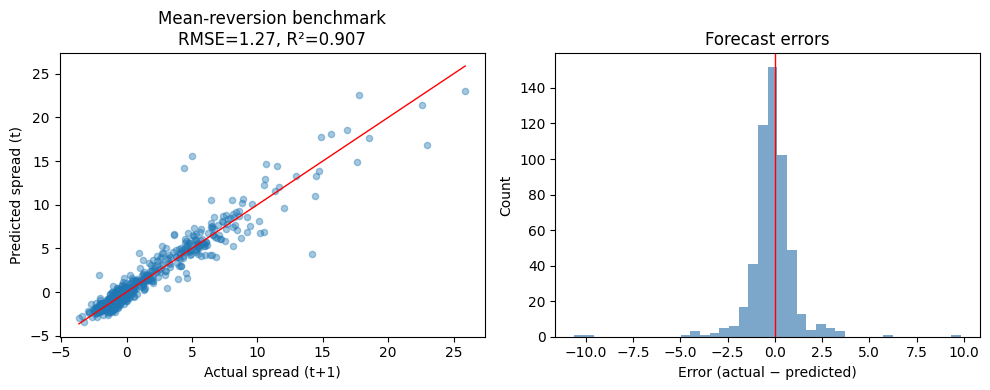

Share of between-country variance in total variance: 90.72%


In [15]:
# mean-reversion as benchmark

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

full = pd.read_pickle("saved/df.dat")[["country", "year", "tgt_spread_t1", "tgt_spread"]].dropna()
fullte = full[full["year"] >= 2015]
y_true = fullte["tgt_spread_t1"]
y_pred = fullte["tgt_spread"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# show fit and prediction error

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=20)
axes[0].plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="-", lw=1)
axes[0].set_xlabel("Actual spread (t+1)")
axes[0].set_ylabel("Predicted spread (t)")
axes[0].set_title(f"Mean-reversion benchmark\nRMSE={rmse:.2f}, R²={r2:.3f}")

errors = y_true - y_pred
axes[1].hist(errors, bins=40, color="steelblue", alpha=0.7)
axes[1].axvline(0, color="red", lw=1)
axes[1].set_title("Forecast errors")
axes[1].set_xlabel("Error (actual − predicted)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

# how much of total variance is explained by between-country variance

df = fullte[["country", "tgt_spread_t1"]].dropna()
overall_mean = df["tgt_spread_t1"].mean()
n_i = df.groupby("country")["tgt_spread_t1"].count()
means_i = df.groupby("country")["tgt_spread_t1"].mean()

# weighted between-country variance

sst_between = ((n_i * (means_i - overall_mean)**2).sum()) / (len(df) - 1)
sst_total = ((df["tgt_spread_t1"] - overall_mean)**2).sum() / (len(df) - 1)
print(f"Share of between-country variance in total variance: {sst_between / sst_total:.2%}")

### Incremental signal

In [145]:
# Load
df = pd.read_pickle("saved/df.dat")

# Define columns
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# Add today's spread level as explanatory variable
macro_cols += ["tgt_spread"]

# Run specification
results = run_unified_regularized_regression(
    name_prefix="signal",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    use_clustering=True,
    corr_threshold=0.9,
    y_name="tgt_spread_t1",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=False,
    param_factors=np.logspace(-3, 10, 25),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=0.907,
    rmse_benchmark=1.27,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)


UNIFIED REGULARIZED REGRESSION: SIGNAL
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2015 (1706 obs)
Test:  2016-2023 (477 obs)

β=1 specification: predicting (spread_t+1 - spread_t)
After removing NaN: 1628 train, 470 test obs

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 59 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,p5d_xrreg,p5d_xconst,0.999254
1,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.999154
2,p5d_democ,p5d_xconst,0.999034
3,p5d_democ,p5d_xrreg,0.997554
4,p5d_autoc,p5d_xrreg,0.997493
5,p5d_autoc,p5d_xconst,0.994855
6,p5d_democ,p5d_autoc,0.991016
7,fiw_b,fiw_pr,0.987694
8,fiw_cl,fiw_f,0.976049
9,fiw_a,fiw_pr,0.971999



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 639
  Number of clusters: 639

Features used in models: 639


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 6.189658188912603



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,0.000483,0.951334,0.720758,2.121580,571,-7.559995,4.041212e-14
1,0.003481,0.001682,0.944765,0.718896,2.128643,473,-7.623428,2.464695e-14
2,0.012115,0.005855,0.932734,0.724349,2.107895,345,-7.619583,2.553513e-14
3,0.042170,0.020380,0.910298,0.820542,1.700788,214,-4.162823,3.143365e-05
4,0.146780,0.070938,0.865333,0.869113,1.452502,81,-2.200452,2.777484e-02
5,0.510897,0.246913,0.821471,0.889893,1.332222,12,-0.520195,6.029275e-01
6,1.778279,0.859430,0.767464,0.894176,1.306056,1,1.148927,2.505863e-01



Best LASSO:
  Parameter: 0.859430
  R² (test): 0.8942
  RMSE (test): 1.3061
  Active vars: 1
  ΔR² vs benchmark: -1.28 p.p.
  ΔRMSE vs benchmark: +0.0361
  DM test: stat=1.15, p=0.251

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.251)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 24297.810658

Factor 74.98942093324558: R² change = 0.000071 (convergence count: 1/3)
Factor 261.0157215682533: R² change = 0.000040 (convergence count: 2/3)
Factor 908.5175756516861: R² change = 0.000014 (convergence count: 3/3)
Early stopping: R² converged (change < 0.0001 for 3 consecutive factors)



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,2.429781e+01,0.938687,0.716348,2.138266,639,-7.582468,3.397282e-14
1,0.003481,8.457340e+01,0.928258,0.748321,2.014152,639,-6.899415,5.221601e-12
2,0.012115,2.943747e+02,0.911045,0.806418,1.766452,639,-5.478612,4.286745e-08
3,0.042170,1.024630e+03,0.885377,0.848329,1.563583,639,-4.461790,8.127792e-06
4,0.146780,3.566431e+03,0.843537,0.873183,1.429744,639,-3.616827,2.982366e-04
5,0.510897,1.241368e+04,0.760978,0.886667,1.351595,639,-1.961515,4.981898e-02
6,1.778279,4.320830e+04,0.654030,0.892159,1.318442,639,0.107923,9.140570e-01
7,6.189658,1.503951e+05,0.584617,0.893632,1.309404,639,1.323794,1.855714e-01
8,21.544347,5.234805e+05,0.556652,0.893757,1.308637,639,1.421045,1.553037e-01
9,74.989421,1.822079e+06,0.547591,0.893686,1.309074,639,1.374550,1.692709e-01



Best RIDGE:
  Parameter: 523480.461736
  R² (test): 0.8938
  RMSE (test): 1.3086
  Active vars: 639
  ΔR² vs benchmark: -1.32 p.p.
  ΔRMSE vs benchmark: +0.0386
  DM test: stat=1.42, p=0.155

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.155)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1.623777

Stopping: model has 0 active variables at factor 6.189658188912603



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.001000,0.001624,0.948070,0.715655,2.140878,580,-7.683150,1.554312e-14,0.25
1,0.003481,0.005652,0.940962,0.709853,2.162609,508,-7.680231,1.598721e-14,0.25
2,0.012115,0.019673,0.929205,0.746008,2.023386,396,-6.950310,3.644862e-12,0.25
3,0.042170,0.068474,0.905504,0.822168,1.693065,292,-4.370374,1.240339e-05,0.25
4,0.146780,0.238338,0.862058,0.872409,1.434098,121,-2.496202,1.255311e-02,0.25
5,0.510897,0.829583,0.813331,0.891227,1.324124,24,-0.303140,7.617829e-01,0.25
6,1.778279,2.887529,0.731761,0.893579,1.309736,9,1.257773,2.084739e-01,0.25



Best ELASTIC (L1=0.25):
  Parameter: 2.887529
  R² (test): 0.8936
  RMSE (test): 1.3097
  Active vars: 9
  ΔR² vs benchmark: -1.34 p.p.
  ΔRMSE vs benchmark: +0.0397
  DM test: stat=1.26, p=0.208

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.208)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.885867

Stopping: model has 0 active variables at factor 6.189658188912603



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.001000,0.000886,0.949981,0.717700,2.133167,579,-7.627529,2.398082e-14,0.5
1,0.003481,0.003083,0.942853,0.710681,2.159521,490,-7.723297,1.132427e-14,0.5
2,0.012115,0.010733,0.931440,0.735113,2.066329,366,-7.310523,2.660094e-13,0.5
3,0.042170,0.037357,0.908544,0.818256,1.711587,240,-4.332337,1.475348e-05,0.5
4,0.146780,0.130027,0.864787,0.869170,1.452186,100,-2.434390,1.491691e-02,0.5
5,0.510897,0.452587,0.817882,0.890431,1.328965,19,-0.520446,6.027527e-01,0.5
6,1.778279,1.575319,0.750031,0.893648,1.309309,7,1.239208,2.152685e-01,0.5



Best ELASTIC (L1=0.5):
  Parameter: 1.575319
  R² (test): 0.8936
  RMSE (test): 1.3093
  Active vars: 7
  ΔR² vs benchmark: -1.34 p.p.
  ΔRMSE vs benchmark: +0.0393
  DM test: stat=1.24, p=0.215

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.215)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Factor 6.189658188912603: R² change = 0.000016 (convergence count: 1/3)
Stopping: model has 0 active variables at factor 21.54434690031882



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p,l1_ratio
0,0.001000,0.000483,0.951534,0.714340,2.145822,592,-7.694144,1.421085e-14,0.75
1,0.003481,0.001682,0.945787,0.719267,2.127235,506,-7.626543,2.420286e-14,0.75
2,0.012115,0.005855,0.935089,0.721338,2.119376,373,-7.688549,1.487699e-14,0.75
3,0.042170,0.020380,0.915500,0.798956,1.800176,256,-5.015691,5.284324e-07,0.75
4,0.146780,0.070938,0.876896,0.859844,1.503056,110,-2.710915,6.709784e-03,0.75
5,0.510897,0.246913,0.828301,0.886400,1.353185,18,-1.370457,1.705444e-01,0.75
6,1.778279,0.859430,0.775471,0.893680,1.309112,4,1.128916,2.589332e-01,0.75
7,6.189658,2.991419,0.564076,0.893664,1.309208,2,1.357975,1.744716e-01,0.75



Best ELASTIC (L1=0.75):
  Parameter: 0.859430
  R² (test): 0.8937
  RMSE (test): 1.3091
  Active vars: 4
  ΔR² vs benchmark: -1.33 p.p.
  ΔRMSE vs benchmark: +0.0391
  DM test: stat=1.13, p=0.259

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.259)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


COMPLETED IN 299.5s



In [143]:
import glob
print(glob.glob("specs/ridge_signal*results.dat"))

['specs/ridge_signal_t2_clust_results.dat', 'specs/ridge_signal_t4_clust_results.dat', 'specs/ridge_signal_t5_clust_results.dat']


### Priced-in level

In [148]:
# Load
df = pd.read_pickle("saved/df.dat")

# Define columns
id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# Run specification
results = run_unified_regularized_regression(
    name_prefix="levels",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    use_clustering=True,
    corr_threshold=0.9,
    y_name="tgt_spread_t5",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=np.logspace(-2, 5, 15),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)


UNIFIED REGULARIZED REGRESSION: LEVELS
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2015 (1902 obs)
Test:  2016-2019 (237 obs)

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 59 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,p5d_xrreg,p5d_xconst,0.999309
1,p5d_democ,p5d_xconst,0.998970
2,p5d_democ,p5d_xrreg,0.997521
3,p5d_autoc,p5d_xrreg,0.996877
4,p5d_autoc,p5d_xconst,0.994232
5,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.991801
6,p5d_democ,p5d_autoc,0.989989
7,fiw_b,fiw_pr,0.988909
8,fiw_cl,fiw_f,0.976845
9,fiw_a,fiw_pr,0.975314



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 653
  Number of clusters: 653

Features used in models: 653


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.078476

Stopping: model has 0 active variables at factor 100.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000785,0.582795,-0.125112,4.390572,627,NaN,NaN
1,0.031623,0.002482,0.569828,0.234472,3.621628,560,NaN,NaN
2,0.100000,0.007848,0.532516,0.334269,3.377323,430,NaN,NaN
3,0.316228,0.024816,0.461335,0.411878,3.174364,285,NaN,NaN
4,1.000000,0.078476,0.344656,0.533370,2.827545,150,NaN,NaN
5,3.162278,0.248163,0.230761,0.504386,2.914036,37,NaN,NaN
6,10.000000,0.784760,0.173730,0.312444,3.432238,12,NaN,NaN
7,31.622777,2.481629,0.022892,0.002075,4.134968,1,NaN,NaN



Best LASSO:
  Parameter: 0.078476
  R² (test): 0.5334
  RMSE (test): 2.8275
  Active vars: 150

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",4.696814,25.785681,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",1.125734,6.180324,7
107,wgi_voiceandaccountability_estimate,"[wgi_voiceandaccountability_estimate_t-3, wgi_...",0.832498,4.570447,4
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-3, efw_2e_legal_inte...",0.773765,4.248000,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.578318,3.174986,6
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_del...,0.577052,3.168034,5
45,efw_5bv_cost_of_worker_dismissal,"[efw_5bv_cost_of_worker_dismissal_t-3, efw_5bv...",0.538618,2.957032,5
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_t-3, wb_iq_spi_pil1_t-1, wb_iq...",0.509784,2.798733,8
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.504589,2.770213,6
28,efw_4bii_costs_of_importing_and_exporting,"[efw_4bii_costs_of_importing_and_exporting, ef...",0.485438,2.665073,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 69 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
17,efw_4dii_capital_controls,[efw_4dii_capital_controls_ma10],1.000,0.226770,0.089352,1
14,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting],1.000,-0.338205,0.086321,1
35,p5d_autoc,[p5d_autoc_ma10],1.000,-0.308705,0.104966,1
27,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_delta],1.000,0.152539,0.050858,1
21,efw_5aiii_interest_rate_controls_negative_real...,[efw_5aiii_interest_rate_controls_negative_rea...,1.000,-0.462232,0.136175,1
41,wb_iq_spi_pil1,[wb_iq_spi_pil1_t-3],1.000,-0.141960,0.054946,1
18,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_ma3],1.000,-0.178186,0.066205,1
0,efw_1b_transfers_and_subsidies,[efw_1b_transfers_and_subsidies],0.990,0.644359,0.151897,1
25,efw_5ci_regulatory_burden,[efw_5ci_regulatory_burden_t-3],0.990,0.126593,0.050375,1
29,efw_gender_disparity_index,"[efw_gender_disparity_index_ma5, efw_gender_di...",0.990,0.403001,0.118843,2



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 571.860368



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,5.718604e+00,0.547830,0.217664,3.661170,653,NaN,NaN
1,0.031623,1.808381e+01,0.509783,0.318728,3.416517,653,NaN,NaN
2,0.100000,5.718604e+01,0.460357,0.389315,3.234685,653,NaN,NaN
3,0.316228,1.808381e+02,0.406568,0.462827,3.033753,653,NaN,NaN
4,1.000000,5.718604e+02,0.353501,0.530479,2.836290,653,NaN,NaN
5,3.162278,1.808381e+03,0.302221,0.571339,2.710067,653,NaN,NaN
6,10.000000,5.718604e+03,0.251108,0.575616,2.696513,653,NaN,NaN
7,31.622777,1.808381e+04,0.201162,0.540185,2.806820,653,NaN,NaN
8,100.000000,5.718604e+04,0.156745,0.465179,3.027106,653,NaN,NaN
9,316.227766,1.808381e+05,0.112868,0.349115,3.339454,653,NaN,NaN



Best RIDGE:
  Parameter: 5718.603680
  R² (test): 0.5756
  RMSE (test): 2.6965
  Active vars: 653

INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3...,0.393841,3.928615,7
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_t-3, wb_iq_spi_pil1_t-1, wb_iq...",0.312186,3.114093,8
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",0.299482,2.987370,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.287495,2.867797,8
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.277909,2.772176,5
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.252789,2.521599,5
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.240328,2.397301,6
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.227158,2.265924,7
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_del...,0.218529,2.179849,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.208338,2.078196,7



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1 ratio=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...


KeyboardInterrupt: 